<img src="http://nlmatics.github.io/site_files/nick_post/squad_image.png" alt="squad" width="300"/>

# Dutch SQuAD 2.0 dataset
*Note:* this dataset is a machine-translated version of the SQuAD v2.0 from Stanford University and can be found [here.](https://gitlab.com/niels.rouws/dutch-squad-v2.0) <br>

**How to use:** <br>
It is best to use Google Colab and run the notebook to get results. <br><br>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [ ]:
# use this cell to install packages if needed
!pip install torch  torchvision -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers

In [1]:
# import libraries
import numpy as np 
import pandas as pd 
import json 
import collections
from pprint import pprint
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

In [ ]:
# Download the Dutch SQuAD2.0 dev set
!wget -P data/squad/ https://gitlab.com/niels.rouws/dutch-squad-v2.0/-/raw/main/nl_squad_dev_filtered.json

# Download the Dutch SQuAD2.0 train set
!wget -P data/squad/ https://gitlab.com/niels.rouws/dutch-squad-v2.0/-/raw/main/nl_squad_train_filtered.json

In [ ]:
from transformers.data.processors.squad import SquadV2Processor

# this processor loads the SQuAD2.0 dev set examples
processor = SquadV2Processor()
examples = processor.get_dev_examples("./data/squad/", filename="nl_squad_dev_filtered.json")
print(len(examples))

In [ ]:
# this processor loads the SQuAD2.0 train set examples
processor = SquadV2Processor()
examples = processor.get_dev_examples("./data/squad/", filename="nl_squad_train_filtered.json")
print(len(examples))

In [ ]:
# generate some maps to help us identify examples of interest
qid_to_example_index = {example.qas_id: i for i, example in enumerate(examples)}
qid_to_has_answer = {example.qas_id: bool(example.answers) for example in examples}
answer_qids = [qas_id for qas_id, has_answer in qid_to_has_answer.items() if has_answer]
no_answer_qids = [qas_id for qas_id, has_answer in qid_to_has_answer.items() if not has_answer]

In [ ]:
# function for checking one example
def display_example(qid):    
    from pprint import pprint

    idx = qid_to_example_index[qid]
    q = examples[idx].question_text
    c = examples[idx].context_text
    a = [answer['text'] for answer in examples[idx].answers]
    
    print(f'Example {idx} of {len(examples)}\n---------------------')
    print(f"Q: {q}\n")
    print("Context:")
    pprint(c)
    print(f"\nTrue Answers:\n{a}")

In [ ]:
display_example(answer_qids[1300])

In [ ]:
display_example(no_answer_qids[1254])

In [ ]:
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [5]:
def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
#     ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
#     js['q_idx'] = ndx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [ ]:
# dev data
input_file_path = '../data/nl_squad_dev_filtered.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path,record_path=record_path)

In [7]:
def load_pandas_df(local_cache_path=".", squad_version="v1.1", file_split="train"):
    """Loads the SQuAD dataset in pandas data frame.
    Args:
        local_cache_path (str, optional): Path to load the data from. If the file doesn't exist,
            download it first. Defaults to the current directory.
        squad_version (str, optional): Version of the SQuAD dataset, accepted values are: 
            "v1.1" and "v2.0". Defaults to "v1.1".
        file_split (str, optional): Dataset split to load, accepted values are: "train" and "dev".
            Defaults to "train".
    """

    if file_split not in ["train", "dev"]:
        raise ValueError("file_split should be either train or dev")

    URL = URL_DICT[squad_version][file_split]
    file_name = URL.split("/")[-1]
    maybe_download(URL, file_name, local_cache_path)

    file_path = os.path.join(local_cache_path, file_name)

    with open(file_path, "r", encoding="utf-8") as reader:
        input_data = json.load(reader)["data"]

    paragraph_text_list = []
    question_text_list = []
    answer_start_list = []
    answer_text_list = []
    qa_id_list = []
    is_impossible_list = []
    for entry in input_data:
        for paragraph in entry["paragraphs"]:
            paragraph_text = paragraph["context"]

            for qa in paragraph["qas"]:
                qas_id = qa["id"]
                question_text = qa["question"]
                answer_offset = None
                is_impossible = False

                if squad_version == "v2.0":
                    is_impossible = qa["is_impossible"]

                if file_split == "train":
                    if (len(qa["answers"]) != 1) and (not is_impossible):
                        raise ValueError(
                            "For training, each question should have exactly 1 answer."
                        )
                    if not is_impossible:
                        answer = qa["answers"][0]
                        orig_answer_text = answer["text"]
                        answer_offset = answer["answer_start"]
                    else:
                        orig_answer_text = ""
                else:
                    if not is_impossible:
                        orig_answer_text = []
                        answer_offset = []
                        for answer in qa["answers"]:
                            orig_answer_text.append(answer["text"])
                            answer_offset.append(answer["answer_start"])
                    else:
                        orig_answer_text = ""

                paragraph_text_list.append(paragraph_text)
                question_text_list.append(question_text)
                answer_start_list.append(answer_offset)
                answer_text_list.append(orig_answer_text)
                qa_id_list.append(qas_id)
                is_impossible_list.append(is_impossible)

    output_df = pd.DataFrame(
        {
            "doc_text": paragraph_text_list,
            "question_text": question_text_list,
            "answer_start": answer_start_list,
            "answer_text": answer_text_list,
            "qa_id": qa_id_list,
            "is_impossible": is_impossible_list,
        }
    )

    return output_df

https://github.com/microsoft/nlp-recipes/blob/master/utils_nlp/dataset/squad.py
Ik ga dit vanavond doen, niet als ik in de zon zit. Het moet wel lukken hiermee

In [2]:
path = '../data/nl_squad_dev_filtered.json'

In [4]:
pd.json_normalize('../data/nl_squad_dev_filtered.json')

NotImplementedError: 

In [ ]:
# Opening JSON file
f = open('../data/squad/nl_squad_dev_filtered.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
# Iterating through the json
# list
for i in data['data']:
    print(i)
  
# Closing file
f.close()

In [9]:
pd.json_normalize(data, max_level=2)

,data
0,"[{'title': '1973_oil_crisis', 'paragraphs': [{..."


In [10]:
pd.json_normalize(data, record_path=['data'])

,title,paragraphs
0,1973_oil_crisis,[{'qas': [{'question': 'Hoeveel was de noodhul...
1,Amazone regenwoud,[{'qas': [{'question': '48 miljoen ton stof wo...
2,Apotheek,[{'qas': [{'question': 'Met wie werken klinisc...
3,Bouw,[{'qas': [{'question': 'Wat is een van de geva...
4,Burgerlijke ongehoorzaamheid,[{'qas': [{'question': 'Aan welk type persoon ...
5,Computational_complexity_theory,[{'qas': [{'question': 'Als de ingangsgrootte ...
6,Ctenophora,[{'qas': [{'question': 'Hoe snel kunnen vissen...
7,Dwingen,[{'qas': [{'question': 'Alle krachten in wat z...
8,Economische ongelijkheid,[{'qas': [{'question': 'Met wat voor soort mot...
9,European_Union_law,[{'qas': [{'question': 'In welke zaak verklaar...


In [17]:
pd.json_normalize(
    data, 
    record_path =['data'],
    meta=['paragraphs', 'qas'],
    errors='ignore'
)

ValueError: Conflicting metadata name paragraphs, need distinguishing prefix 

In [19]:
!pip3 install utils_nlp

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
ERROR: Could not find a version that satisfies the requirement utils_nlp (from versions: none)
ERROR: No matching distribution found for utils_nlp


In [3]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import os
import json
import pandas as pd

#from utils_nlp.dataset.url_utils import maybe_download

URL_DICT = {
    "v1.1": {
        "train": "https://raw.githubusercontent.com/rajpurkar/SQuAD-explorer/"
        "master/dataset/train-v1.1.json",
        "dev": "https://raw.githubusercontent.com/rajpurkar/SQuAD-explorer/"
        "master/dataset/dev-v1.1.json",
    },
    "v2.0": {
        "train": "https://raw.githubusercontent.com/rajpurkar/SQuAD-explorer/"
        "master/dataset/train-v2.0.json",
        "dev": "https://raw.githubusercontent.com/rajpurkar/SQuAD-explorer/"
        "master/dataset/dev-v2.0.json",
    },
}


def load_pandas_df(local_cache_path=".", squad_version="v1.1", file_split="train"):
    """Loads the SQuAD dataset in pandas data frame.
    Args:
        local_cache_path (str, optional): Path to load the data from. If the file doesn't exist,
            download it first. Defaults to the current directory.
        squad_version (str, optional): Version of the SQuAD dataset, accepted values are: 
            "v1.1" and "v2.0". Defaults to "v1.1".
        file_split (str, optional): Dataset split to load, accepted values are: "train" and "dev".
            Defaults to "train".
    """

    if file_split not in ["train", "dev"]:
        raise ValueError("file_split should be either train or dev")

    URL = URL_DICT[squad_version][file_split]
    file_name = URL.split("/")[-1]
    #maybe_download(URL, file_name, local_cache_path)

    file_path = os.path.join(local_cache_path, file_name)

    with open(file_path, "r", encoding="utf-8") as reader:
        input_data = json.load(reader)["data"]

    paragraph_text_list = []
    question_text_list = []
    answer_start_list = []
    answer_text_list = []
    qa_id_list = []
    is_impossible_list = []
    for entry in input_data:
        for paragraph in entry["paragraphs"]:
            paragraph_text = paragraph["context"]

            for qa in paragraph["qas"]:
                qas_id = qa["id"]
                question_text = qa["question"]
                answer_offset = None
                is_impossible = False

                if squad_version == "v2.0":
                    is_impossible = qa["is_impossible"]

                if file_split == "train":
                    if (len(qa["answers"]) != 1) and (not is_impossible):
                        raise ValueError(
                            "For training, each question should have exactly 1 answer."
                        )
                    if not is_impossible:
                        answer = qa["answers"][0]
                        orig_answer_text = answer["text"]
                        answer_offset = answer["answer_start"]
                    else:
                        orig_answer_text = ""
                else:
                    if not is_impossible:
                        orig_answer_text = []
                        answer_offset = []
                        for answer in qa["answers"]:
                            orig_answer_text.append(answer["text"])
                            answer_offset.append(answer["answer_start"])
                    else:
                        orig_answer_text = ""

                paragraph_text_list.append(paragraph_text)
                question_text_list.append(question_text)
                answer_start_list.append(answer_offset)
                answer_text_list.append(orig_answer_text)
                qa_id_list.append(qas_id)
                is_impossible_list.append(is_impossible)

    output_df = pd.DataFrame(
        {
            "doc_text": paragraph_text_list,
            "question_text": question_text_list,
            "answer_start": answer_start_list,
            "answer_text": answer_text_list,
            "qa_id": qa_id_list,
            "is_impossible": is_impossible_list,
        }
    )

    return output_df

In [4]:
df_dev = load_pandas_df(local_cache_path="../data/squad", squad_version="v2.0", file_split="dev")

In [5]:
df_dev.head()

,doc_text,question_text,answer_start,answer_text,qa_id,is_impossible
0,Als reactie op Amerikaanse hulp aan Israël ver...,Hoeveel was de noodhulp aan Israël?,[471],"[$ 2,2 miljard]",5725bcb6271a42140099d0ee,False
1,Als reactie op Amerikaanse hulp aan Israël ver...,Waar kwam Nixon op 20 oktober 1973 bij?,None,,5a38b29da4b263001a8c18ab,True
2,Als reactie op Amerikaanse hulp aan Israël ver...,Waarom blokkeerde OPEC de olieleveringen naar ...,[15],[Amerikaanse hulp aan Israël],5725bcb6271a42140099d0ef,False
3,Als reactie op Amerikaanse hulp aan Israël ver...,Waarom hebben de olieministers ingestemd met e...,[361],[totdat hun economische en politieke doelstell...,5725bcb6271a42140099d0ed,False
4,Als reactie op Amerikaanse hulp aan Israël ver...,"Waarom verhoogde OPEC de olieprijs naar $ 5,11?",[0],[Als reactie op Amerikaanse hulp aan Israël],5725bcb6271a42140099d0eb,False


In [29]:
!pip install seaborn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached scipy-1.8.1.tar.gz (38.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [189 lines of output]
      setup.py:486: UserWarning: Unrecognized setuptools command ('dist_info --egg-base /private/var/folders/z8/mnh7b0x15b73wxpj_pgc93vr0000gn/T/pip-modern-metadata-lam9qrab'), proceeding with generating Cython sources and expanding templates
        warnings.warn("Unrecognized setuptools command ('{}'), proceeding with "
      Running from SciPy sou

In [6]:
# Code Snippet for Top Non-Stopwords Barchart

import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('dutch'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x).set(title='Top Non-Stopwords')

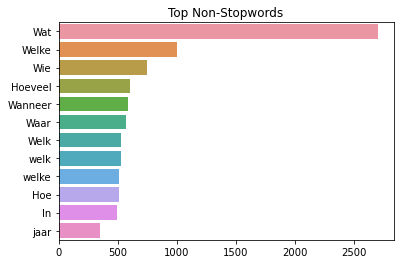

In [7]:
plot_top_non_stopwords_barchart(df_dev['question_text'])

<AxesSubplot:>

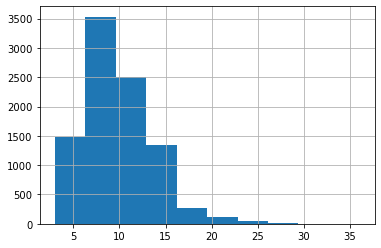

In [8]:
df_dev['question_text'].str.split().\
    map(lambda x: len(x)).\
    hist()

In [22]:
# answer contains brackets, because it is a list of strings
# lets remove them
#df_dev['answer_text'] = df_dev['answer_text'].apply(lambda x: x.replace('[', ''))
#df_dev['answer_text'] = df_dev['answer_text'].apply(lambda x: x.replace(']', ''))

df_dev['answer_text'] = df_dev['answer_text'].replace(to_replace=r'[', value='', regex=True)
df_dev['answer_text'] = df_dev['answer_text'].replace(to_replace=r']', value='', regex=True)

error: unterminated character set at position 0

In [21]:
df_dev.head()

,doc_text,question_text,answer_start,answer_text,qa_id,is_impossible
0,Als reactie op Amerikaanse hulp aan Israël ver...,Hoeveel was de noodhulp aan Israël?,[471],"[$ 2,2 miljard]",5725bcb6271a42140099d0ee,False
1,Als reactie op Amerikaanse hulp aan Israël ver...,Waar kwam Nixon op 20 oktober 1973 bij?,None,,5a38b29da4b263001a8c18ab,True
2,Als reactie op Amerikaanse hulp aan Israël ver...,Waarom blokkeerde OPEC de olieleveringen naar ...,[15],[Amerikaanse hulp aan Israël],5725bcb6271a42140099d0ef,False
3,Als reactie op Amerikaanse hulp aan Israël ver...,Waarom hebben de olieministers ingestemd met e...,[361],[totdat hun economische en politieke doelstell...,5725bcb6271a42140099d0ed,False
4,Als reactie op Amerikaanse hulp aan Israël ver...,"Waarom verhoogde OPEC de olieprijs naar $ 5,11?",[0],[Als reactie op Amerikaanse hulp aan Israël],5725bcb6271a42140099d0eb,False


<AxesSubplot:>

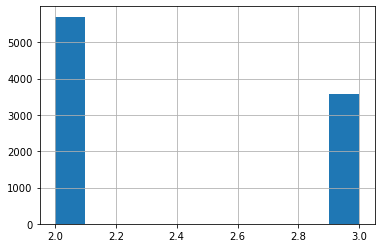

In [20]:
# this chart is not right, due to float types
df_dev['answer_text'].str.split().\
    map(lambda x: len(str(x))).\
    hist()

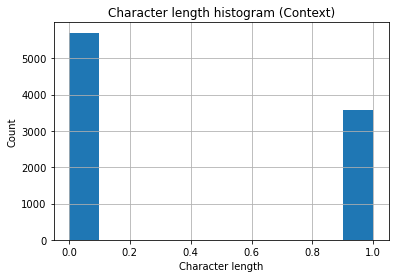

In [17]:
def plot_character_length_histogram(text):
    text.str.len().\
        hist().set(xlabel='Character length', ylabel='Count', title='Character length histogram (Context)')

plot_character_length_histogram(df_dev['answer_text'])

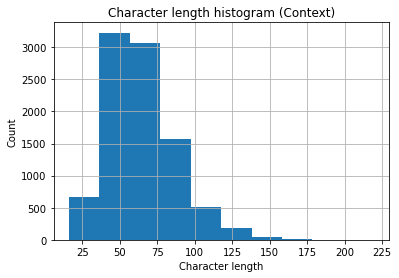

In [14]:
def plot_character_length_histogram(text):
    text.str.len().\
        hist().set(xlabel='Character length', ylabel='Count', title='Character length histogram (Context)')

plot_character_length_histogram(df_dev['question_text'])

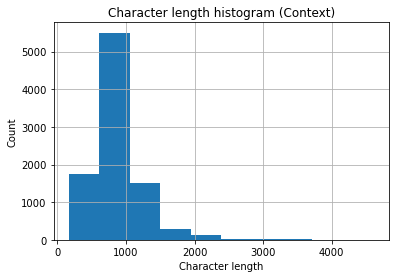

In [15]:
def plot_character_length_histogram(text):
    text.str.len().\
        hist().set(xlabel='Character length', ylabel='Count', title='Character length histogram (Context)')

plot_character_length_histogram(df_dev['doc_text'])